**Import Necessary Libraries**

In [1]:
# Importing required libraries for data manipulation, model training, and evaluation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, Add, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Confirm libraries are loaded
print("Libraries imported successfully.")


Libraries imported successfully.


**Load Dataset**

In [2]:
# Loading dataset from CSV file to analyze and preprocess
data_path = 'Patient_Health_Data.csv'
patient_data = pd.read_csv(data_path)

# Print the first few rows to understand the structure of the data
print("Dataset loaded. Here are the first few rows:")
print(patient_data.head())


Dataset loaded. Here are the first few rows:
  Patient_ID  Height_cm  Weight_kg Blood_Pressure  Temperature_C  Heart_Rate  \
0      P0001      174.0       59.0         120/80           36.6        63.0   
1      P0002        NaN       67.0         130/85           37.0        68.0   
2      P0003      176.0       58.0         140/90           37.0        65.0   
3      P0004      185.0       65.0         125/82           37.2        69.0   
4      P0005      167.0       41.0         135/88           36.3        72.0   

              Symptoms Existing_Conditions      Disease_Predictions  \
0           chest pain            Diabetes            Heart Disease   
1  shortness of breath        Hypertension  Coronary Artery Disease   
2              fatigue    High Cholesterol               Arrhythmia   
3            dizziness                 NaN                      NaN   
4         palpitations              Asthma             Hypertension   

  Laboratory_Test_Results  Cholesterol_mg_dL  B

**Display Data Structure**

In [3]:
print("Dataset structure:")
print(patient_data.info())

Dataset structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Patient_ID                    2000 non-null   object 
 1   Height_cm                     1915 non-null   float64
 2   Weight_kg                     1914 non-null   float64
 3   Blood_Pressure                1640 non-null   object 
 4   Temperature_C                 1892 non-null   float64
 5   Heart_Rate                    1903 non-null   float64
 6   Symptoms                      1562 non-null   object 
 7   Existing_Conditions           1488 non-null   object 
 8   Disease_Predictions           1488 non-null   object 
 9   Laboratory_Test_Results       1505 non-null   object 
 10  Cholesterol_mg_dL             1899 non-null   float64
 11  Blood_Sugar_mg_dL             1880 non-null   float64
 12  Family_History_Heart_Disease  1891 non-null

In [4]:
unique_symptoms = patient_data['Laboratory_Test_Results'].unique()
print("Unique values in the 'Symptoms' column:")
print(unique_symptoms)

Unique values in the 'Symptoms' column:
['High Cholesterol' nan 'Normal' 'High Blood Sugar' 'Low Iron']



Initial Data Overview:
--------------------------------------------------
Dataset shape: (2000, 14)

First few rows of the dataset:


,Patient_ID,Height_cm,Weight_kg,Blood_Pressure,Temperature_C,Heart_Rate,Symptoms,Existing_Conditions,Disease_Predictions,Laboratory_Test_Results,Cholesterol_mg_dL,Blood_Sugar_mg_dL,Family_History_Heart_Disease,Smoking_Status
0,P0001,174.0,59.0,120/80,36.6,63.0,chest pain,Diabetes,Heart Disease,High Cholesterol,198.0,79.0,Yes,Never
1,P0002,NaN,67.0,130/85,37.0,68.0,shortness of breath,Hypertension,Coronary Artery Disease,NaN,179.0,90.0,No,Former
2,P0003,176.0,58.0,140/90,37.0,65.0,fatigue,High Cholesterol,Arrhythmia,Normal,193.0,82.0,NaN,Current
3,P0004,185.0,65.0,125/82,37.2,69.0,dizziness,NaN,NaN,NaN,228.0,103.0,No,Never
4,P0005,167.0,41.0,135/88,36.3,72.0,palpitations,Asthma,Hypertension,NaN,251.0,135.0,Yes,Former



Missing Values Analysis:
--------------------------------------------------
Height_cm                        85
Weight_kg                        86
Blood_Pressure                  360
Temperature_C                   108
Heart_Rate                       97
Symptoms                        438
Existing_Conditions             512
Disease_Predictions             512
Laboratory_Test_Results         495
Cholesterol_mg_dL               101
Blood_Sugar_mg_dL               120
Family_History_Heart_Disease    109
Smoking_Status                   89
dtype: int64


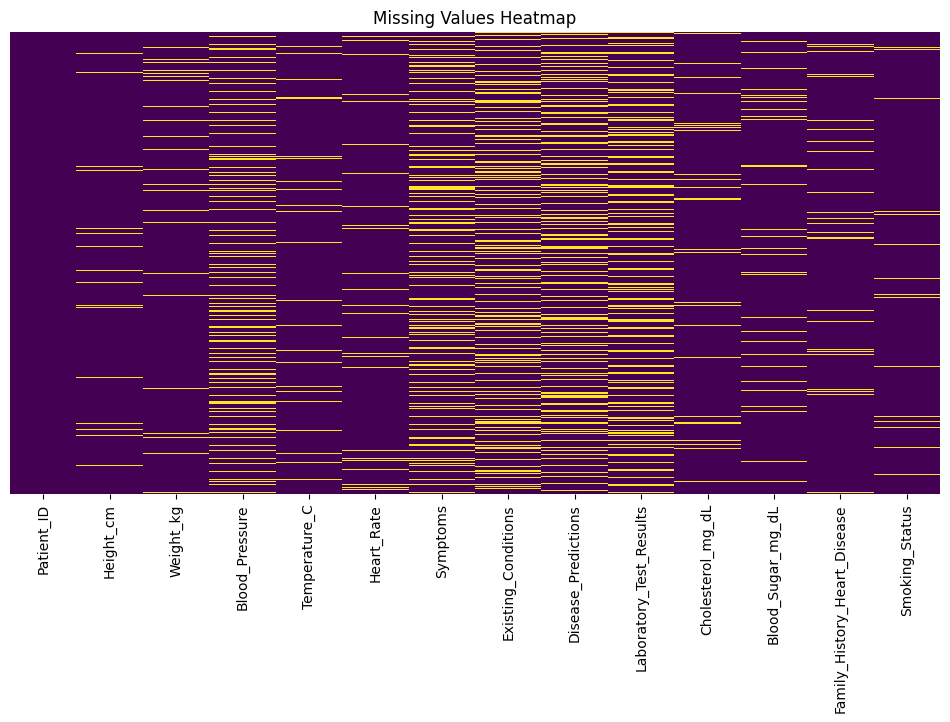

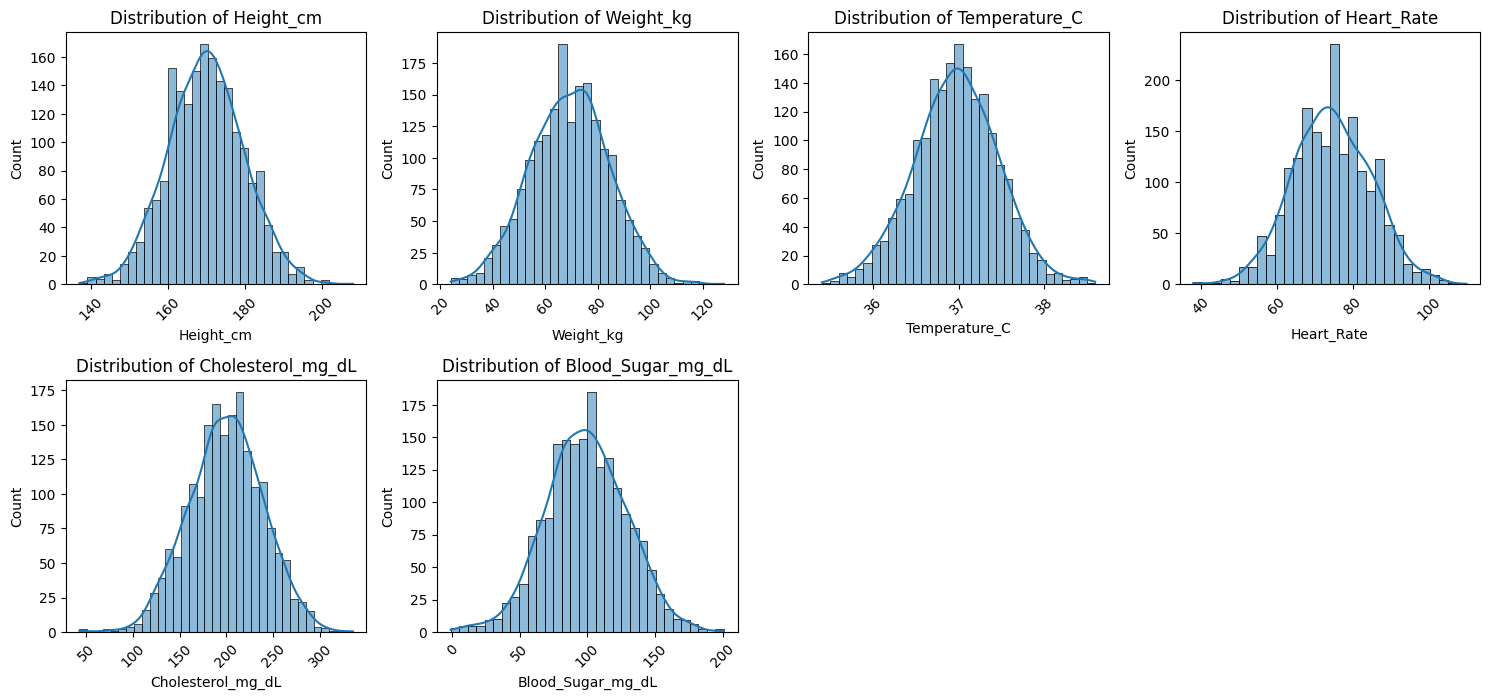

In [5]:
# After loading data
print("\nInitial Data Overview:")
print("-" * 50)
print("Dataset shape:", patient_data.shape)
print("\nFirst few rows of the dataset:")
display(patient_data.head())

# After preprocessing
print("\nMissing Values Analysis:")
print("-" * 50)
missing_values = patient_data.isnull().sum()
print(missing_values[missing_values > 0])

# Visualize missing values
plt.figure(figsize=(12, 6))
sns.heatmap(patient_data.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# Add distribution plots for numerical features
numerical_cols = patient_data.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 4, i)
    sns.histplot(patient_data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Splitting 'Blood_Pressure' Column**

In [6]:
# Split the 'Blood_Pressure' column into 'Systolic_BP' and 'Diastolic_BP'
# This separation helps in individual analysis of each blood pressure component
patient_data[['Systolic_BP', 'Diastolic_BP']] = patient_data['Blood_Pressure'].str.split('/', expand=True)

# Verify the split by viewing the updated DataFrame
print("Blood pressure split into 'Systolic_BP' and 'Diastolic_BP':")
print(patient_data[['Systolic_BP', 'Diastolic_BP']].head())
print(patient_data[['Systolic_BP', 'Diastolic_BP']].info())


Blood pressure split into 'Systolic_BP' and 'Diastolic_BP':
  Systolic_BP Diastolic_BP
0         120           80
1         130           85
2         140           90
3         125           82
4         135           88
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Systolic_BP   1640 non-null   object
 1   Diastolic_BP  1640 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
None


**Convert Blood Pressure Columns to Numeric**

In [7]:
# Convert the new blood pressure columns to numeric and handle non-numeric entries by setting them to NaN
# This is necessary for further analysis since we can’t process string values in these columns
patient_data['Systolic_BP'] = pd.to_numeric(patient_data['Systolic_BP'], errors='coerce')
patient_data['Diastolic_BP'] = pd.to_numeric(patient_data['Diastolic_BP'], errors='coerce')

# Check the data types and any potential NaNs introduced during conversion
print("Converted 'Systolic_BP' and 'Diastolic_BP' to numeric types:")
print(patient_data[['Systolic_BP', 'Diastolic_BP']].info())


Converted 'Systolic_BP' and 'Diastolic_BP' to numeric types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Systolic_BP   1640 non-null   float64
 1   Diastolic_BP  1640 non-null   float64
dtypes: float64(2)
memory usage: 31.4 KB
None


**Drop the Original 'Blood_Pressure' Column**

In [8]:
# Drop the original 'Blood_Pressure' column as it is no longer needed
patient_data = patient_data.drop(columns=['Blood_Pressure'])

# Confirm the column is dropped
print("'Blood_Pressure' column dropped:")
print(patient_data.head())


'Blood_Pressure' column dropped:
  Patient_ID  Height_cm  Weight_kg  Temperature_C  Heart_Rate  \
0      P0001      174.0       59.0           36.6        63.0   
1      P0002        NaN       67.0           37.0        68.0   
2      P0003      176.0       58.0           37.0        65.0   
3      P0004      185.0       65.0           37.2        69.0   
4      P0005      167.0       41.0           36.3        72.0   

              Symptoms Existing_Conditions      Disease_Predictions  \
0           chest pain            Diabetes            Heart Disease   
1  shortness of breath        Hypertension  Coronary Artery Disease   
2              fatigue    High Cholesterol               Arrhythmia   
3            dizziness                 NaN                      NaN   
4         palpitations              Asthma             Hypertension   

  Laboratory_Test_Results  Cholesterol_mg_dL  Blood_Sugar_mg_dL  \
0        High Cholesterol              198.0               79.0   
1              

**Fill Missing Values for Numerical Columns**

In [9]:
# Fill missing values in numerical columns with the mean of each column
patient_data.fillna(patient_data.median(numeric_only=True), inplace=True)

# Check for remaining missing values in the DataFrame
print("Filled missing values in numerical columns. Checking for nulls:")
print(patient_data.isnull().sum())


Filled missing values in numerical columns. Checking for nulls:
Patient_ID                        0
Height_cm                         0
Weight_kg                         0
Temperature_C                     0
Heart_Rate                        0
Symptoms                        438
Existing_Conditions             512
Disease_Predictions             512
Laboratory_Test_Results         495
Cholesterol_mg_dL                 0
Blood_Sugar_mg_dL                 0
Family_History_Heart_Disease    109
Smoking_Status                   89
Systolic_BP                       0
Diastolic_BP                      0
dtype: int64


**Fill Missing Values for Categorical Columns**

In [10]:
# Fill missing values in categorical columns with the mode (most frequent value) of each column
for col in patient_data.select_dtypes(include=['object']).columns:
    patient_data[col].fillna(patient_data[col].mode()[0], inplace=True)

# Confirm no missing values remain in categorical columns
print("Filled missing values in categorical columns. Checking for nulls:")
print(patient_data.isnull().sum())


Filled missing values in categorical columns. Checking for nulls:
Patient_ID                      0
Height_cm                       0
Weight_kg                       0
Temperature_C                   0
Heart_Rate                      0
Symptoms                        0
Existing_Conditions             0
Disease_Predictions             0
Laboratory_Test_Results         0
Cholesterol_mg_dL               0
Blood_Sugar_mg_dL               0
Family_History_Heart_Disease    0
Smoking_Status                  0
Systolic_BP                     0
Diastolic_BP                    0
dtype: int64


C:\Users\vaibh\AppData\Local\Temp\ipykernel_21744\1065955776.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  patient_data[col].fillna(patient_data[col].mode()[0], inplace=True)


**Separate Features and Target Variable**

In [11]:
# Separate the features and target variable for model training
X = patient_data.drop(columns=['Disease_Predictions', 'Patient_ID'])
y = patient_data['Disease_Predictions']

# Display the shapes to ensure correct separation
print("Separated features (X) and target (y):")
print("Features shape:", X.shape)
print("Target shape:", y.shape)


Separated features (X) and target (y):
Features shape: (2000, 13)
Target shape: (2000,)


**Encode Target Variable**

In [12]:
# Encode the categorical target variable using LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Print unique classes to confirm encoding
print("Encoded target variable:")
print("Classes:", label_encoder.classes_)


Encoded target variable:
Classes: ['Arrhythmia' 'Coronary Artery Disease' 'Heart Disease' 'Hypertension'
 'Stroke']


**One-Hot Encode and Standardize Features**

In [13]:
# One-hot encode categorical features and standardize numerical features for better model performance
X = pd.get_dummies(X, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Confirm the scaling and encoding by displaying shape and sample data
print("Features encoded and standardized. Sample data:")
print(X_scaled[:5])
print(X_scaled.shape)
# Visualize the first few rows of the scaled and encoded features
pd.DataFrame(X_scaled, columns=X.columns).head()


Features encoded and standardized. Sample data:
[[ 0.42511947 -0.70767243 -0.77023217 -1.14595273 -0.04247373 -0.68912389
  -1.62040061 -1.61665691 -0.38655567 -0.38655567 -0.38740968 -0.73460594
  -0.38655567  2.38515476 -0.41926001 -0.41595736 -0.82845678  2.08508839
  -0.48196047 -0.48038446  1.06511582 -0.68363106  1.46784677]
 [ 0.00971019 -0.16409303  0.05675177 -0.64943941 -0.5368081  -0.31023836
  -0.3207009  -0.31573399 -0.38655567 -0.38655567 -0.38740968 -0.73460594
   2.5869495  -0.41926001 -0.41926001  2.40409256 -0.82845678 -0.47959598
  -0.48196047 -0.48038446 -0.93886503  1.4627773  -0.68127002]
 [ 0.6328241  -0.77561986  0.05675177 -0.9473474  -0.17256172 -0.58579147
   0.9789988   0.98518892 -0.38655567  2.5869495  -0.38740968 -0.73460594
  -0.38655567 -0.41926001  2.38515476 -0.41595736 -0.82845678 -0.47959598
  -0.48196047  2.081666   -0.93886503 -0.68363106 -0.68127002]
 [ 1.56749497 -0.29998788  0.47024374 -0.55013675  0.73805422  0.13753545
  -0.97055076 -1.096287

,Height_cm,Weight_kg,Temperature_C,Heart_Rate,Cholesterol_mg_dL,Blood_Sugar_mg_dL,Systolic_BP,Diastolic_BP,Symptoms_dizziness,Symptoms_fatigue,...,Existing_Conditions_Diabetes,Existing_Conditions_High Cholesterol,Existing_Conditions_Hypertension,Existing_Conditions_Thyroid,Laboratory_Test_Results_High Cholesterol,Laboratory_Test_Results_Low Iron,Laboratory_Test_Results_Normal,Family_History_Heart_Disease_Yes,Smoking_Status_Former,Smoking_Status_Never
0,0.425119,-0.707672,-0.770232,-1.145953,-0.042474,-0.689124,-1.620401,-1.616657,-0.386556,-0.386556,...,2.385155,-0.419260,-0.415957,-0.828457,2.085088,-0.48196,-0.480384,1.065116,-0.683631,1.467847
1,0.009710,-0.164093,0.056752,-0.649439,-0.536808,-0.310238,-0.320701,-0.315734,-0.386556,-0.386556,...,-0.419260,-0.419260,2.404093,-0.828457,-0.479596,-0.48196,-0.480384,-0.938865,1.462777,-0.681270
2,0.632824,-0.775620,0.056752,-0.947347,-0.172562,-0.585791,0.978999,0.985189,-0.386556,2.586949,...,-0.419260,2.385155,-0.415957,-0.828457,-0.479596,-0.48196,2.081666,-0.938865,-0.683631,-0.681270
3,1.567495,-0.299988,0.470244,-0.550137,0.738054,0.137535,-0.970551,-1.096288,2.586949,-0.386556,...,-0.419260,-0.419260,-0.415957,1.207064,-0.479596,-0.48196,-0.480384,-0.938865,-0.683631,1.467847
4,-0.301847,-1.930726,-1.390470,-0.252229,1.336459,1.239748,0.329149,0.464820,-0.386556,-0.386556,...,-0.419260,-0.419260,-0.415957,-0.828457,-0.479596,-0.48196,-0.480384,1.065116,1.462777,-0.681270


**Apply SMOTE to Balance Classes**

In [14]:
# Use SMOTE to balance the classes by oversampling the minority classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y_encoded)

# Confirm the balanced classes
print("Applied SMOTE to balance classes. New class distribution:")
print(np.bincount(y_resampled))


Applied SMOTE to balance classes. New class distribution:
[815 815 815 815 815]


**Split into Training and Test Sets**

In [15]:
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(3260, 23)
(407, 23)
(408, 23)
(3260,)
(407,)
(408,)


**Model 1: K-Nearest Neighbors (KNN)**

KNN Validation Accuracy: 0.9238329238329238
KNN Validation Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97        95
           1       0.94      0.99      0.96        82
           2       0.94      0.97      0.96        79
           3       0.93      0.70      0.80        82
           4       0.85      0.97      0.91        69

    accuracy                           0.92       407
   macro avg       0.92      0.92      0.92       407
weighted avg       0.93      0.92      0.92       407

KNN Test Accuracy: 0.928921568627451
KNN Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        85
           1       0.95      0.97      0.96        78
           2       0.93      0.97      0.95        73
           3       0.94      0.73      0.82        86
           4       0.88      0.98      0.92        86

    accuracy                    

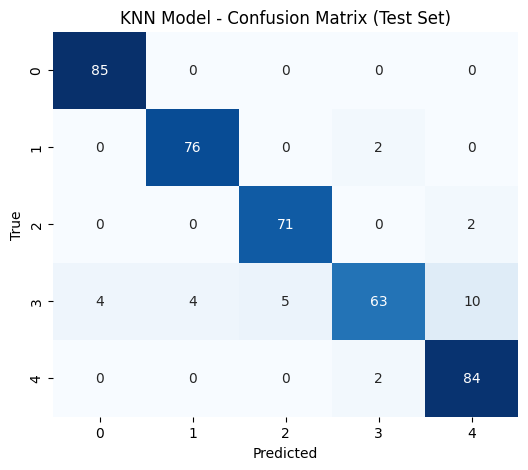

In [16]:
# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model to the training data
knn.fit(X_train, y_train)

# Predict on the validation set
knn_val_pred = knn.predict(X_val)

# Evaluate KNN on the validation set
print("KNN Validation Accuracy:", accuracy_score(y_val, knn_val_pred))
print("KNN Validation Classification Report:\n", classification_report(y_val, knn_val_pred))

# Predict on the test set
knn_test_pred = knn.predict(X_test)

# Evaluate KNN on the test set
print("KNN Test Accuracy:", accuracy_score(y_test, knn_test_pred))
print("KNN Test Classification Report:\n", classification_report(y_test, knn_test_pred))

# Plot confusion matrix for the test set
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, knn_test_pred), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("KNN Model - Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Best parameters found by GridSearchCV: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Best KNN Validation Accuracy: 0.9238329238329238
Best KNN Validation Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        95
           1       0.95      0.99      0.97        82
           2       0.93      0.97      0.95        79
           3       0.96      0.67      0.79        82
           4       0.82      0.99      0.89        69

    accuracy                           0.92       407
   macro avg       0.92      0.92      0.92       407
weighted avg       0.93      0.92      0.92       407

Best KNN Test Accuracy: 0.9387254901960784
Best KNN Test Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        85
           1       0.94      0.97      0.96        78
           2       0.94      0.99      0.96        73
           3    

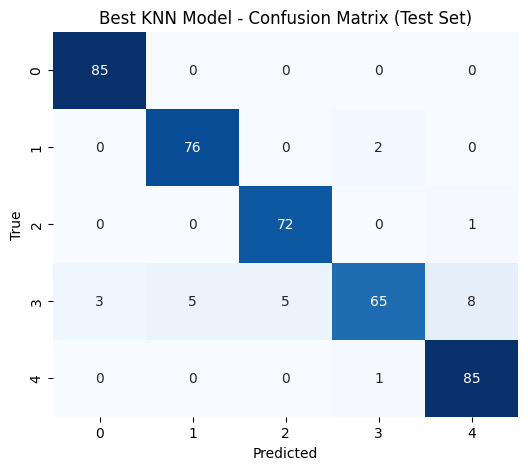

In [17]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize the KNN model
knn = KNeighborsClassifier()

# Initialize GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_knn = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found by GridSearchCV:", best_params)

# Predict on the validation set using the best KNN model
knn_val_pred = best_knn.predict(X_val)

# Evaluate the best KNN model on the validation set
print("Best KNN Validation Accuracy:", accuracy_score(y_val, knn_val_pred))
print("Best KNN Validation Classification Report:\n", classification_report(y_val, knn_val_pred))

# Predict on the test set using the best KNN model
knn_test_pred = best_knn.predict(X_test)

# Evaluate the best KNN model on the test set
print("Best KNN Test Accuracy:", accuracy_score(y_test, knn_test_pred))
print("Best KNN Test Classification Report:\n", classification_report(y_test, knn_test_pred))

# Plot confusion matrix for the test set
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, knn_test_pred), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Best KNN Model - Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [18]:
# import joblib

# # Save the scaler
# scaler_filename = 'scaler.pkl'
# joblib.dump(scaler, scaler_filename)

# # Save the label encoder
# label_encoder_filename = 'label_encoder.pkl'
# joblib.dump(label_encoder, label_encoder_filename)

# # Save the SMOTE object
# smote_filename = 'smote.pkl'
# joblib.dump(smote, smote_filename)

# # Save the KNN model
# knn_model_filename = 'knn_model.pkl'
# joblib.dump(best_knn, knn_model_filename)

# print("Preprocessing steps and KNN model saved successfully.")

Accuracy is low, so lets move to RandomForest

**Model 2: RandomForest**

RandomForest Validation Accuracy: 0.9459459459459459
RandomForest Validation Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        95
           1       0.95      0.99      0.97        82
           2       0.94      0.99      0.96        79
           3       0.94      0.79      0.86        82
           4       0.93      0.96      0.94        69

    accuracy                           0.95       407
   macro avg       0.94      0.94      0.94       407
weighted avg       0.95      0.95      0.94       407

RandomForest Test Accuracy: 0.9583333333333334
RandomForest Test Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        85
           1       0.97      0.99      0.98        78
           2       0.94      1.00      0.97        73
           3       0.96      0.84      0.89        86
           4       0.95      0.98      0.97       

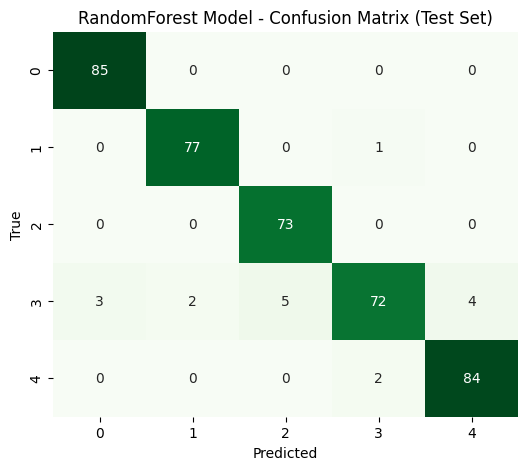

In [19]:
# Initialize the RandomForest model
rf = RandomForestClassifier(random_state=42)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Predict on the validation set
rf_val_pred = rf.predict(X_val)

# Evaluate RandomForest on the validation set
print("RandomForest Validation Accuracy:", accuracy_score(y_val, rf_val_pred))
print("RandomForest Validation Classification Report:\n", classification_report(y_val, rf_val_pred))

# Predict on the test set
rf_test_pred = rf.predict(X_test)

# Evaluate RandomForest on the test set
print("RandomForest Test Accuracy:", accuracy_score(y_test, rf_test_pred))
print("RandomForest Test Classification Report:\n", classification_report(y_test, rf_test_pred))

# Plot confusion matrix for the test set
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, rf_test_pred), annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("RandomForest Model - Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

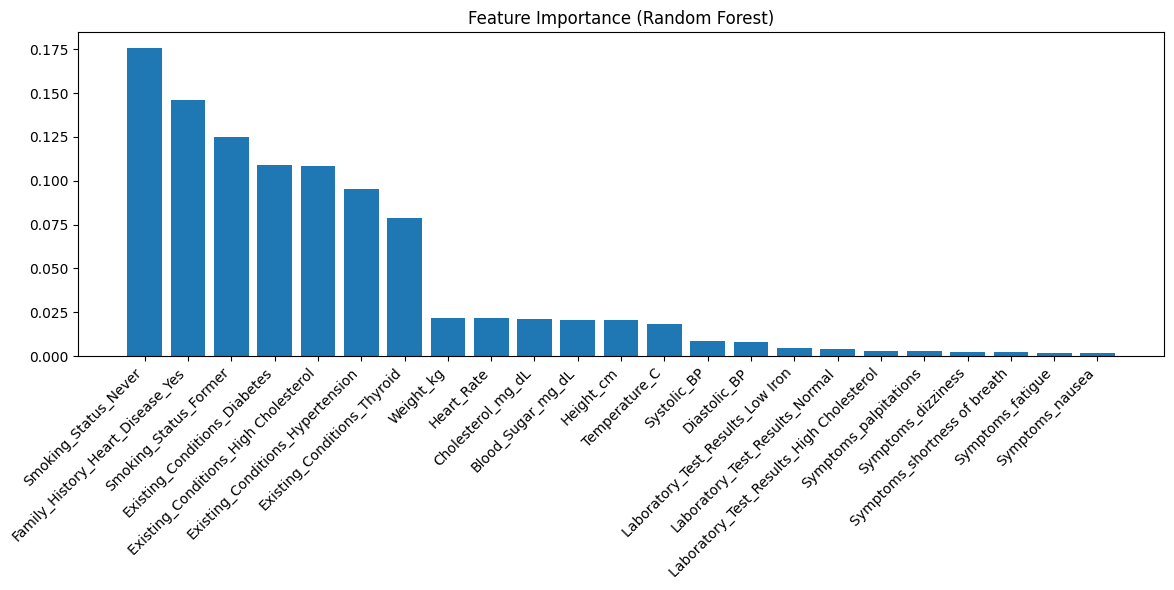

In [20]:
def plot_feature_importance(model, feature_names, title):
    """
    Plot feature importance for tree-based models
    """
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title(f"Feature Importance ({title})")
    plt.bar(range(len(importance)), importance[indices])
    plt.xticks(range(len(importance)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Plot feature importance for Random Forest
plot_feature_importance(rf, X.columns, "Random Forest")

d:\HEART_DISEASE_PREDICTION\hdp\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters found by GridSearchCV for RandomForest: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best RandomForest Validation Accuracy: 0.9459459459459459
Best RandomForest Validation Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        95
           1       0.95      0.99      0.97        82
           2       0.94      0.99      0.96        79
           3       0.94      0.79      0.86        82
           4       0.93      0.96      0.94        69

    accuracy                           0.95       407
   macro avg       0.94      0.94      0.94       407
weighted avg       0.95      0.95      0.94       407

Best RandomForest Test Accuracy: 0.9558823529411765
Best RandomForest Test Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        85
           1       0.96     

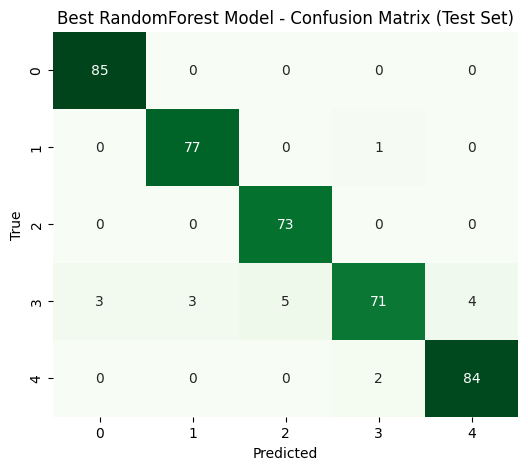

In [21]:
# Define the parameter grid for GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForest model
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with cross-validation
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_rf = grid_search_rf.best_params_
best_rf = grid_search_rf.best_estimator_

# Print the best parameters
print("Best parameters found by GridSearchCV for RandomForest:", best_params_rf)

# Predict on the validation set using the best RandomForest model
rf_val_pred = best_rf.predict(X_val)

# Evaluate the best RandomForest model on the validation set
print("Best RandomForest Validation Accuracy:", accuracy_score(y_val, rf_val_pred))
print("Best RandomForest Validation Classification Report:\n", classification_report(y_val, rf_val_pred))

# Predict on the test set using the best RandomForest model
rf_test_pred = best_rf.predict(X_test)

# Evaluate the best RandomForest model on the test set
print("Best RandomForest Test Accuracy:", accuracy_score(y_test, rf_test_pred))
print("Best RandomForest Test Classification Report:\n", classification_report(y_test, rf_test_pred))

# Plot confusion matrix for the test set
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, rf_test_pred), annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Best RandomForest Model - Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

d:\HEART_DISEASE_PREDICTION\hdp\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:45:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost with RandomForest Feature Validation Accuracy: 0.9459459459459459
XGBoost with RandomForest Feature Validation Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        95
           1       0.95      0.99      0.97        82
           2       0.94      0.99      0.96        79
           3       0.94      0.79      0.86        82
           4       0.93      0.96      0.94        69

    accuracy                           0.95       407
   macro avg       0.94      0.94      0.94       407
weighted avg       0.95      0.95      0.94       407

XGBoost with RandomForest Feature Test Accuracy: 0.9583333333333334
XGBoost with RandomForest Feature Test Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        85
           1       0.96      0.99      0.97        78
           2       0.94      1.00      0.97        73
           3       0

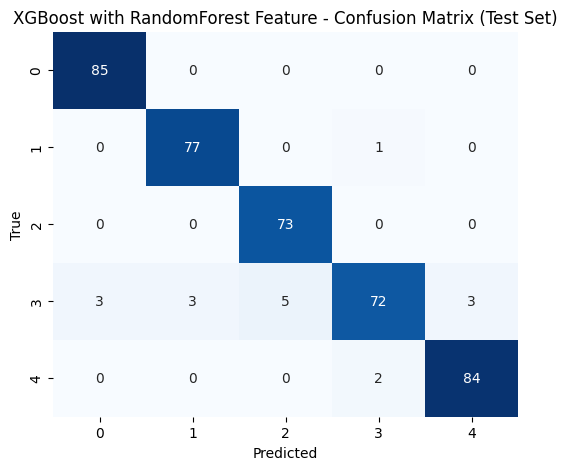

In [22]:
# Add RandomForest predictions as a new feature to the training and test sets
X_train_with_rf = np.hstack((X_train, best_rf.predict(X_train).reshape(-1, 1)))
X_val_with_rf = np.hstack((X_val, best_rf.predict(X_val).reshape(-1, 1)))
X_test_with_rf = np.hstack((X_test, best_rf.predict(X_test).reshape(-1, 1)))

# Initialize the XGBoost model
xgb_with_rf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# Fit the model to the training data with the additional RandomForest feature
xgb_with_rf.fit(X_train_with_rf, y_train)

# Predict on the validation set
xgb_with_rf_val_pred = xgb_with_rf.predict(X_val_with_rf)

# Evaluate the XGBoost model with the additional RandomForest feature on the validation set
print("XGBoost with RandomForest Feature Validation Accuracy:", accuracy_score(y_val, xgb_with_rf_val_pred))
print("XGBoost with RandomForest Feature Validation Classification Report:\n", classification_report(y_val, xgb_with_rf_val_pred))

# Predict on the test set
xgb_with_rf_test_pred = xgb_with_rf.predict(X_test_with_rf)

# Evaluate the XGBoost model with the additional RandomForest feature on the test set
print("XGBoost with RandomForest Feature Test Accuracy:", accuracy_score(y_test, xgb_with_rf_test_pred))
print("XGBoost with RandomForest Feature Test Classification Report:\n", classification_report(y_test, xgb_with_rf_test_pred))

# Plot confusion matrix for the test set
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, xgb_with_rf_test_pred), annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("XGBoost with RandomForest Feature - Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

Accuracy is still low,so lets move to CNN

**Reshape for CNN Input**

In [23]:
# Reshape the data for CNN input, adding a third dimension for channels (required by Conv1D)
X_train_reshaped = np.expand_dims(X_train, axis=2)
X_val_reshaped = np.expand_dims(X_val, axis=2)
X_test_reshaped = np.expand_dims(X_test, axis=2)

# Confirm reshaping
print("Data reshaped for CNN input:")
print("X_train reshaped shape:", X_train_reshaped.shape)
print("X_val reshaped shape:", X_val_reshaped.shape)
print("X_test reshaped shape:", X_test_reshaped.shape)


Data reshaped for CNN input:
X_train reshaped shape: (3260, 23, 1)
X_val reshaped shape: (407, 23, 1)
X_test reshaped shape: (408, 23, 1)


**Convert Target Variable to Categorical**

In [24]:
# Convert target variable to categorical format for multi-class classification
y_train_categorical = to_categorical(y_train)
y_val_categorical = to_categorical(y_val)
y_test_categorical = to_categorical(y_test)

# Confirm conversion
print("Converted target to categorical format:")
print("y_train shape:", y_train_categorical.shape)
print("y_val shape:", y_val_categorical.shape)
print("y_test shape:", y_test_categorical.shape)


Converted target to categorical format:
y_train shape: (3260, 5)
y_val shape: (407, 5)
y_test shape: (408, 5)


**Define the Deep Residual CNN Mode**

In [25]:
# Function to build a deep residual CNN model with Conv1D layers
def build_residual_cnn(input_shape, num_classes):
    input_layer = Input(shape=input_shape)
    
    # First Conv1D Block
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    # Second Conv1D Block with residual connection
    residual = Conv1D(128, kernel_size=3, padding='same')(x)  # Adjust dimensions with padding
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Add()([x, residual])  # Add residual connection
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.4)(x)

    # Third Conv1D Block
    x = Conv1D(256, kernel_size=3, activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.5)(x)

    # Flatten and Dense Layers
    x = Flatten()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Build the model
model = build_residual_cnn(input_shape=(X_train_reshaped.shape[1], 1), num_classes=y_train_categorical.shape[1])

# Display model summary
model.summary()
print("Deep residual CNN model defined.")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 23, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 23, 64)    │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 23, 64)    │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 11, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 11, 64)    │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 11, 128)   │     24,704 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 11, 128)   │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 11, 128)   │     24,704 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 11, 128)   │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 5, 128)    │          0 │ add[0][0]         │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5, 128)    │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 5, 256)    │     98,560 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 5, 256)    │      1,024 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 2, 256)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2, 256)    │          0 │ max_pooling1d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 512)       │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    262,656 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5)         │      2,565 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 415,237 (1.58 MB)

 Trainable params: 414,341 (1.58 MB)

 Non-trainable params: 896 (3.50 KB)

Deep residual CNN model defined.


**Compile the Model**

In [26]:
# Compile the model with Adam optimizer and categorical crossentropy loss for multi-class classification
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
print("Model compiled.")


Model compiled.


**Set Up Callbacks**

In [27]:
# Define callbacks for early stopping, model checkpoint, and reducing learning rate on plateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_residual_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]

print("Callbacks set up.")


Callbacks set up.


**Train the Model**

In [28]:
# Train the model with the training data and validate on test data using callbacks
history = model.fit(X_train_reshaped, y_train_categorical, epochs=100, batch_size=64, validation_data=(X_test_reshaped, y_test_categorical), callbacks=callbacks, verbose=1)
print("Model training completed.")


Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.3508 - loss: 3.0716 - val_accuracy: 0.2353 - val_loss: 2.1552 - learning_rate: 0.0010
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6427 - loss: 1.8466 - val_accuracy: 0.2941 - val_loss: 2.2076 - learning_rate: 0.0010
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7592 - loss: 1.4947 - val_accuracy: 0.6569 - val_loss: 1.6968 - learning_rate: 0.0010
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7937 - loss: 1.3700 - val_accuracy: 0.7500 - val_loss: 1.4955 - learning_rate: 0.0010
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8264 - loss: 1.2636 - val_accuracy: 0.8235 - val_loss: 1.2920 - learning_rate: 0.0010
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8532 - loss: 1.1795 - val_accuracy: 0.8529 - val_loss: 1.1759 - learning_rate: 0.0010
Epoch 7/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8901 - loss: 1.0565 - 

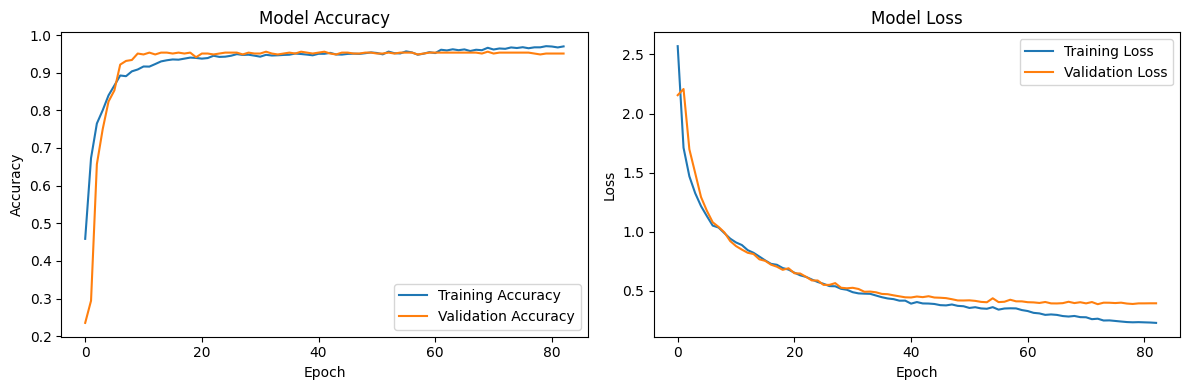

In [29]:
def plot_training_history(history):
    """
    Plot training history for the CNN model
    """
    plt.figure(figsize=(12, 4))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# After training the CNN
plot_training_history(history)

**Load Best Weights and Evaluate**

Loaded best model weights.
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
CNN Accuracy: 0.9534313725490197
CNN Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98        85
           1       0.95      0.99      0.97        78
           2       0.94      1.00      0.97        73
           3       0.95      0.83      0.88        86
           4       0.97      0.97      0.97        86

    accuracy                           0.95       408
   macro avg       0.95      0.96      0.95       408
weighted avg       0.95      0.95      0.95       408



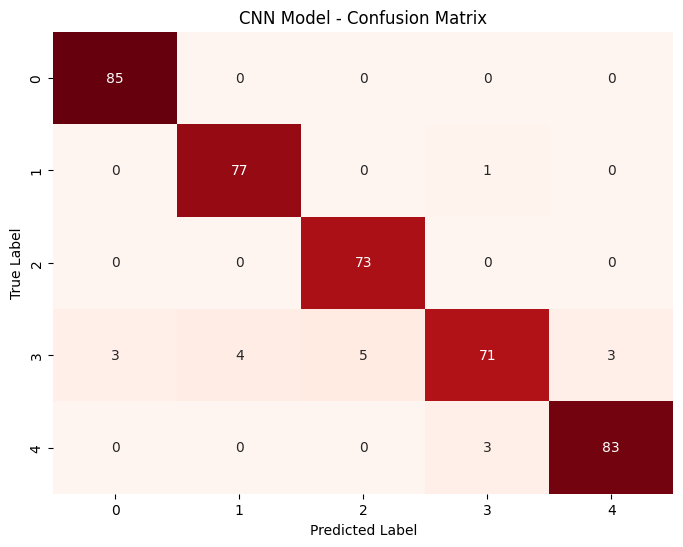

In [30]:
# Load the best model weights from training
model.load_weights('best_residual_model.keras')
print("Loaded best model weights.")

# Evaluate CNN using categorical predictions
cnn_pred_prob = model.predict(X_test_reshaped)
cnn_pred = np.argmax(cnn_pred_prob, axis=1)
y_test_classes = np.argmax(y_test_categorical, axis=1)

# Calculate and display metrics
print("CNN Accuracy:", accuracy_score(y_test_classes, cnn_pred))
print("CNN Classification Report:\n", classification_report(y_test_classes, cnn_pred))

# Plot confusion matrix
plt.figure(figsize=(8,6))
cm = confusion_matrix(y_test_classes, cnn_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", cbar=False)
plt.title("CNN Model - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**Summary & Model Comparison**

In [31]:
def plot_model_comparison(models_results):
    """
    Plot comparison of model performances
    """
    plt.figure(figsize=(12, 6))
    
    # Accuracy comparison
    accuracies = []
    names = []
    
    # KNN results
    knn_val_accuracy = accuracy_score(y_val, knn_val_pred)
    accuracies.append(knn_val_accuracy)
    names.append('KNN')
    
    # Random Forest results  
    rf_val_accuracy = accuracy_score(y_val, rf_val_pred)
    accuracies.append(rf_val_accuracy)
    names.append('Random Forest')

    # XGBoost with RF results
    xgb_rf_val_accuracy = accuracy_score(y_val, xgb_with_rf_val_pred)
    accuracies.append(xgb_rf_val_accuracy)
    names.append('XGBoost+RF')

    # CNN results
    cnn_val_accuracy = accuracy_score(np.argmax(y_val_categorical, axis=1), 
                                    np.argmax(model.predict(X_val_reshaped), axis=1))
    accuracies.append(cnn_val_accuracy)
    names.append('CNN')

    # Plot accuracies
    plt.bar(range(len(accuracies)), accuracies)
    plt.xticks(range(len(accuracies)), names, rotation=45)
    plt.title('Model Validation Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    
    # Add value labels on top of bars
    for i, v in enumerate(accuracies):
        plt.text(i, v + 0.01, f'{v:.3f}', 
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Store model results
models_results = []


KNN Evaluation Results:
--------------------------------------------------
Accuracy: 0.9387

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        85
           1       0.94      0.97      0.96        78
           2       0.94      0.99      0.96        73
           3       0.96      0.76      0.84        86
           4       0.90      0.99      0.94        86

    accuracy                           0.94       408
   macro avg       0.94      0.94      0.94       408
weighted avg       0.94      0.94      0.94       408



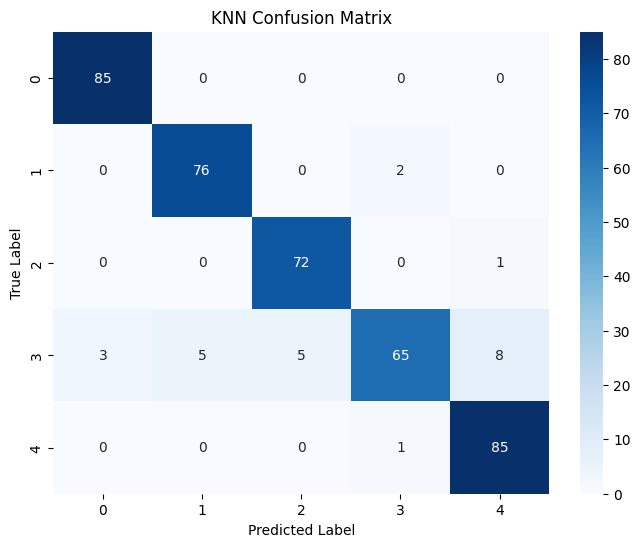


Random Forest Evaluation Results:
--------------------------------------------------
Accuracy: 0.9559

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        85
           1       0.96      0.99      0.97        78
           2       0.94      1.00      0.97        73
           3       0.96      0.83      0.89        86
           4       0.95      0.98      0.97        86

    accuracy                           0.96       408
   macro avg       0.96      0.96      0.96       408
weighted avg       0.96      0.96      0.95       408



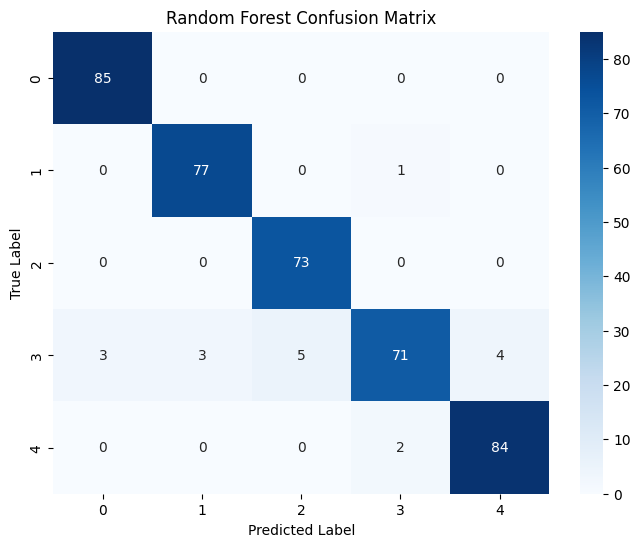


XGBoost+RF Evaluation Results:
--------------------------------------------------
Accuracy: 0.9583

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        85
           1       0.96      0.99      0.97        78
           2       0.94      1.00      0.97        73
           3       0.96      0.84      0.89        86
           4       0.97      0.98      0.97        86

    accuracy                           0.96       408
   macro avg       0.96      0.96      0.96       408
weighted avg       0.96      0.96      0.96       408



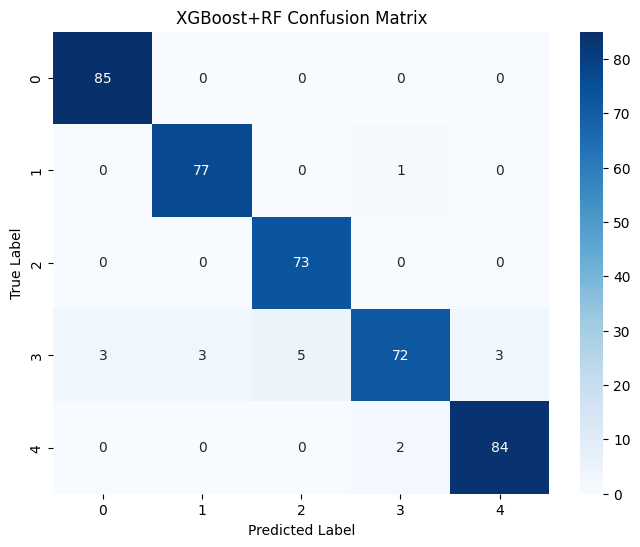


CNN Evaluation Results:
--------------------------------------------------
Accuracy: 0.9534

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        85
           1       0.95      0.99      0.97        78
           2       0.94      1.00      0.97        73
           3       0.95      0.83      0.88        86
           4       0.97      0.97      0.97        86

    accuracy                           0.95       408
   macro avg       0.95      0.96      0.95       408
weighted avg       0.95      0.95      0.95       408



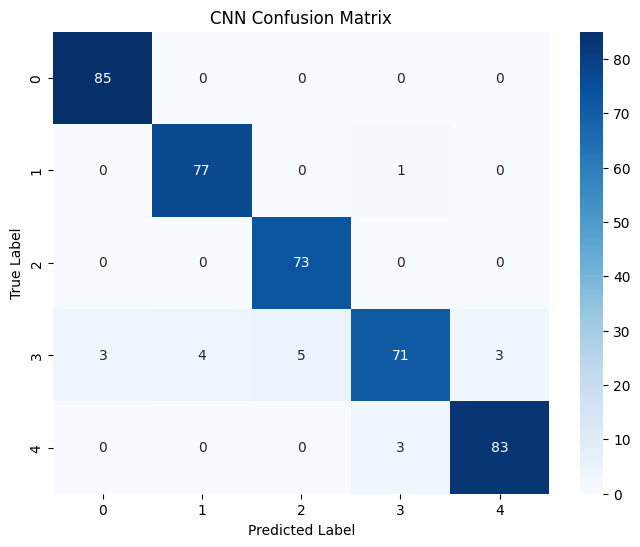

In [32]:
def evaluate_model(model, y_true, y_pred, model_name):
    """
    Evaluate model performance with multiple metrics
    """
    # Convert predictions to class labels if using CNN
    if model_name == "CNN":
        y_true = np.argmax(y_true, axis=1)
        y_pred = np.argmax(y_pred, axis=1)
        
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    print(f"\n{model_name} Evaluation Results:")
    print("-" * 50)
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)
    
    # Plot confusion matrix with improved visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    
    return {
        'name': model_name,
        'model': model,
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix
    }

# Evaluate models and store results
models_results = [
    evaluate_model(knn, y_test, knn_test_pred, "KNN"),
    evaluate_model(best_rf, y_test, rf_test_pred, "Random Forest"),
    evaluate_model(xgb_with_rf, y_test, xgb_with_rf_test_pred, "XGBoost+RF"),
    evaluate_model(model, y_test_categorical, cnn_pred_prob, "CNN")
]


Model Comparison Summary:
KNN:
  - Accuracy: 0.9387
Random Forest:
  - Accuracy: 0.9559
XGBoost+RF:
  - Accuracy: 0.9583
CNN:
  - Accuracy: 0.9534

Best performing model: XGBoost+RF with accuracy 0.9583


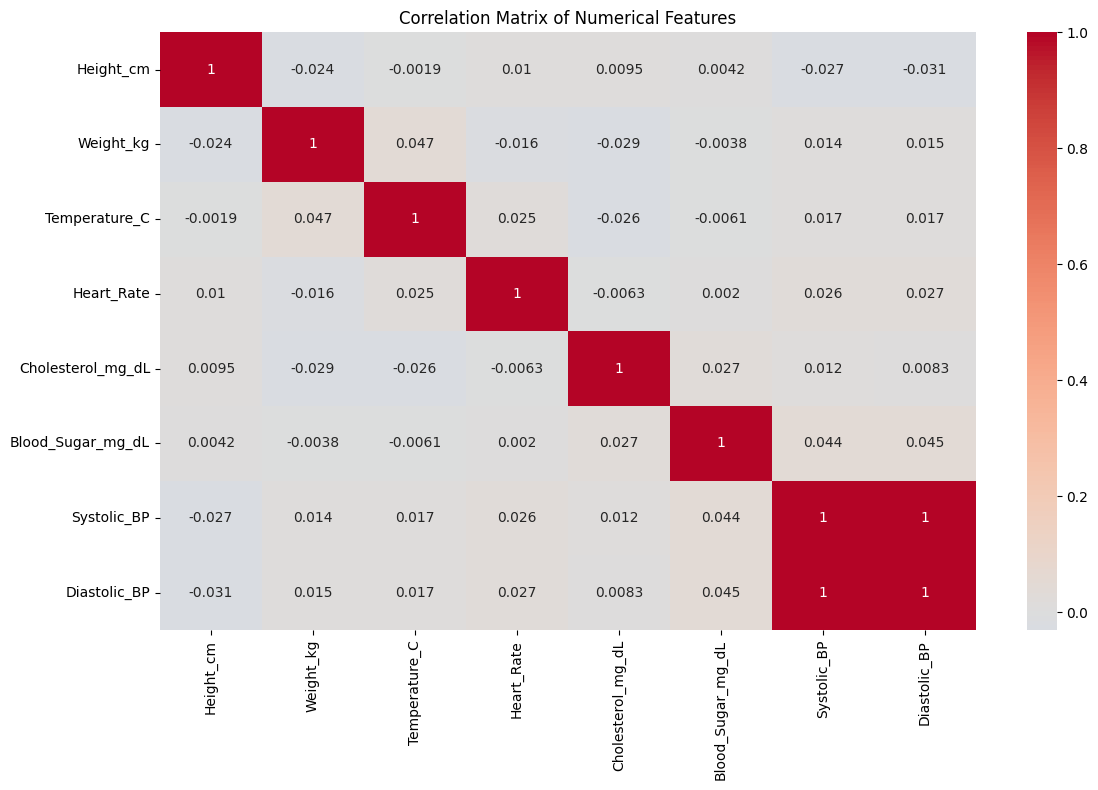

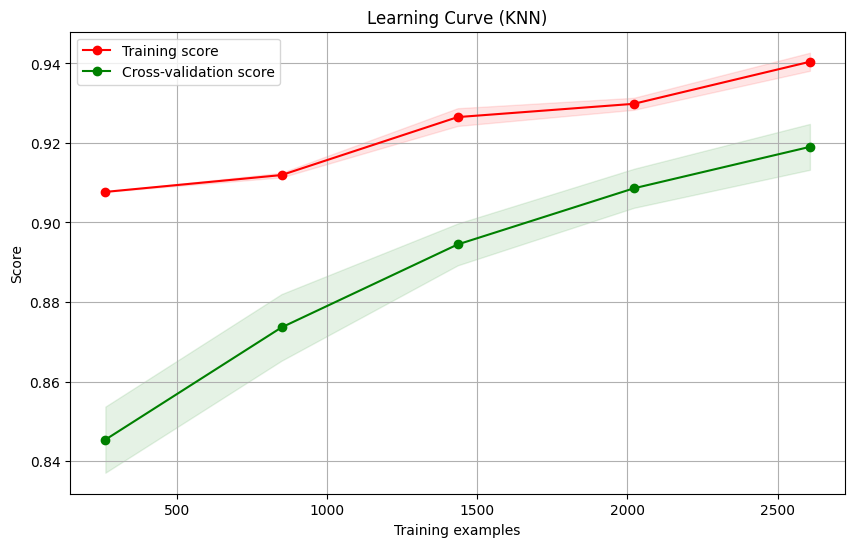

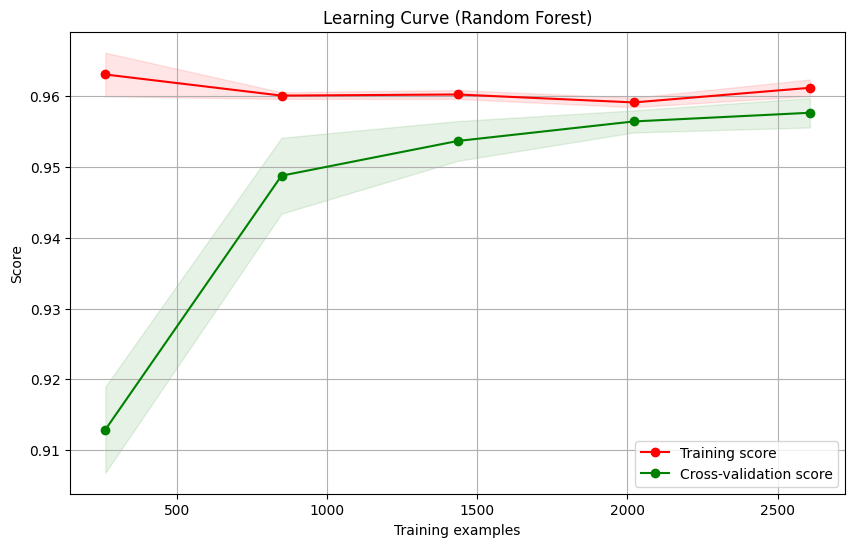

d:\HEART_DISEASE_PREDICTION\hdp\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\HEART_DISEASE_PREDICTION\hdp\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\HEART_DISEASE_PREDICTION\hdp\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:46:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
d:\HEART_DISEASE_PREDI

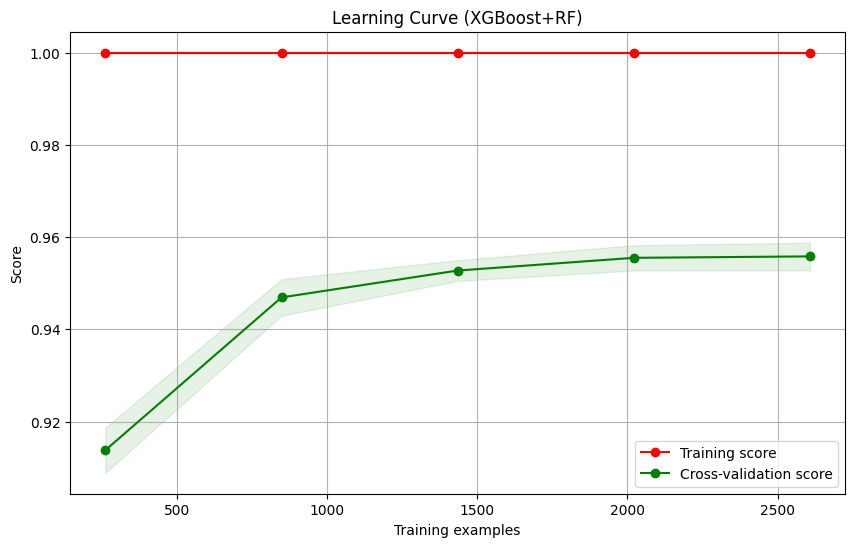

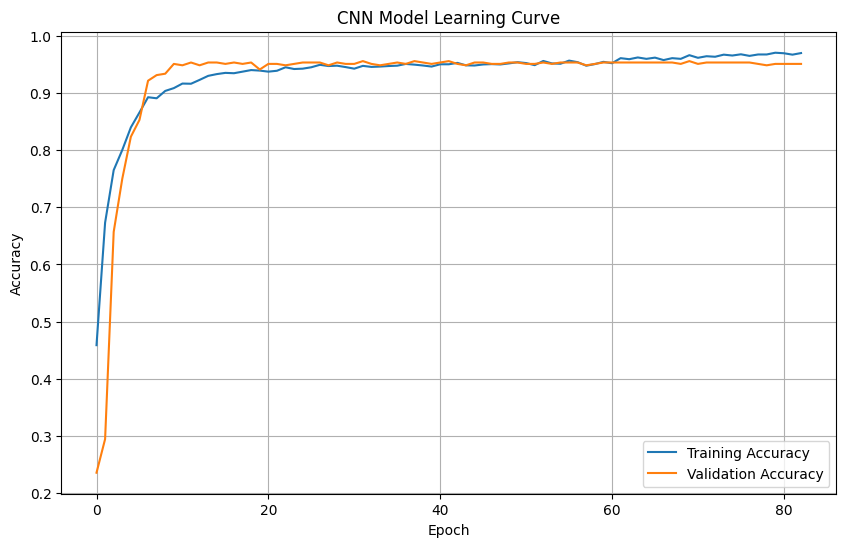


Final Analysis and Conclusions:
1. Best performing model: XGBoost+RF
2. Overall accuracy achieved: 0.9583


In [33]:
print("\nModel Comparison Summary:")
print("=" * 50)
for result in models_results:
    print(f"{result['name']}:")
    print(f"  - Accuracy: {result['accuracy']:.4f}")

best_model = max(models_results, key=lambda x: x['accuracy'])
print(f"\nBest performing model: {best_model['name']} with accuracy {best_model['accuracy']:.4f}")

# Add correlation matrix visualization
plt.figure(figsize=(12, 8))
numerical_cols = X.select_dtypes(include=['float64']).columns
correlation_matrix = patient_data[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# Add learning curves for each model
def plot_sklearn_learning_curve(estimator, title, X, y, ylim=None, cv=5,
                              n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Plot learning curve for sklearn models
    """
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, 
        train_sizes=train_sizes,
        scoring='accuracy'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

def plot_cnn_learning_curve(history):
    """
    Plot learning curve for CNN model using training history
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('CNN Model Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Plot learning curves based on model type
for result in models_results:
    if result['name'] == 'CNN':
        plot_cnn_learning_curve(history)
    else:
        plot_sklearn_learning_curve(
            result['model'],
            f"Learning Curve ({result['name']})",
            X_train, y_train
        )

# Final conclusions
print("\nFinal Analysis and Conclusions:")
print("=" * 50)
print(f"1. Best performing model: {best_model['name']}")
print(f"2. Overall accuracy achieved: {best_model['accuracy']:.4f}")

**Saving the Model**

In [34]:
# import joblib

# # Save the XGBoost+RF model to a .pkl file
# joblib.dump(xgb_with_rf, 'xgboost_rf_model.pkl')

# print("Model saved successfully.")

**User Interface for the Application**

In [38]:
# Import necessary libraries
import pandas as pd
import numpy as np
from ipywidgets import widgets, Layout, HBox, VBox
from IPython.display import display, HTML, clear_output
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import load_model

# Load your dataset and set up encoders and scaler
data_path = 'Patient_Health_Data.csv'
patient_data = pd.read_csv(data_path)

# Drop the 'Patient_ID' column if it exists
patient_data = patient_data.drop(columns=['Patient_ID'], errors='ignore')

# Splitting 'Blood_Pressure' into 'Systolic_BP' and 'Diastolic_BP'
patient_data[['Systolic_BP', 'Diastolic_BP']] = patient_data['Blood_Pressure'].str.split('/', expand=True)

# Convert new columns to numeric, handle non-numeric entries by setting them to NaN
patient_data['Systolic_BP'] = pd.to_numeric(patient_data['Systolic_BP'], errors='coerce')
patient_data['Diastolic_BP'] = pd.to_numeric(patient_data['Diastolic_BP'], errors='coerce')

# Drop the original 'Blood_Pressure' column as it's no longer needed
patient_data = patient_data.drop(columns=['Blood_Pressure'])

# Prepare label encoders and scaler based on training
label_encoder = LabelEncoder()
patient_data['Disease_Predictions'] = patient_data['Disease_Predictions'].fillna(patient_data['Disease_Predictions'].mode()[0])
y_encoded = label_encoder.fit_transform(patient_data['Disease_Predictions'])

# Fill missing values for numerical columns
patient_data.fillna(patient_data.median(numeric_only=True), inplace=True)

# Fill missing values for categorical columns
for col in patient_data.select_dtypes(include=['object']).columns:
    patient_data[col] = patient_data[col].fillna(patient_data[col].mode()[0])

# Define features and scaler based on training data
numeric_features = patient_data.select_dtypes(include=[np.number]).columns.drop(['Disease_Predictions'], errors='ignore').tolist()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(patient_data[numeric_features])

# Load pre-trained CNN model
model = load_model('best_residual_model.keras')

# Display title and introduction with enhanced styling
display(HTML("<h1 style='color: #00796B; font-size: 30px; text-align: center;'>Patient Health Prediction System</h1>"))
display(HTML("<p style='color: #616161; font-size: 16px; text-align: center;'>Please provide the patient's health details below and click <strong style='color: #388E3C;'>Predict Disease</strong> for a health assessment.</p>"))

# Set up widgets with color themes, tooltips, and placeholders
feature_widgets = {}

# Create interactive sliders for numerical features with colorful handles and descriptions
for feature in numeric_features:
    tooltip = f"Set the value for {feature.replace('_', ' ')}"
    if feature == 'Systolic_BP':
        feature_widgets[feature] = widgets.IntSlider(value=120, min=40, max=200, step=1, description="Systolic BP",
                                                     style={'description_width': 'initial', 'handle_color': '#29B6F6'}, layout=Layout(width='100%'), tooltip=tooltip)
    elif feature == 'Diastolic_BP':
        feature_widgets[feature] = widgets.IntSlider(value=80, min=40, max=120, step=1, description="Diastolic BP",
                                                     style={'description_width': 'initial', 'handle_color': '#EF5350'}, layout=Layout(width='100%'), tooltip=tooltip)
    elif feature == 'Temperature_C':
        feature_widgets[feature] = widgets.FloatSlider(value=37.0, min=30.0, max=44.0, step=0.1, description="Temperature",
                                                       style={'description_width': 'initial', 'handle_color': '#66BB6A'}, layout=Layout(width='100%'), tooltip=tooltip)
    else:
        min_val = patient_data[feature].min()
        max_val = patient_data[feature].max()
        feature_widgets[feature] = widgets.IntSlider(value=int((min_val + max_val) / 2),
                                                     min=int(min_val),
                                                     max=int(max_val),
                                                     step=1,
                                                     description=feature.replace('_', ' ').title(),
                                                     style={'description_width': 'initial', 'handle_color': '#FFA726'}, layout=Layout(width='100%'), tooltip=tooltip)

# Dropdown menus for categorical features with placeholders and colors
for feature in patient_data.select_dtypes(include=['object']).columns:
    if feature != 'Disease_Predictions':
        unique_values = patient_data[feature].dropna().unique()
        options = [('Select...', None)] + [(str(val), str(val)) for val in sorted(unique_values)]
        feature_widgets[feature] = widgets.Dropdown(options=options, description=feature.replace('_', ' ').title(),
                                                    style={'description_width': 'initial'}, layout=Layout(width='100%'))

# Organize the input widgets into two columns with stylish borders
numeric_widgets = VBox([feature_widgets[feature] for feature in numeric_features], layout=Layout(width='48%', border='2px solid #B2DFDB', padding='20px', margin='10px'))
categorical_widgets = VBox([feature_widgets[feature] for feature in patient_data.select_dtypes(include=['object']).columns if feature != 'Disease_Predictions'],
                           layout=Layout(width='48%', border='2px solid #FFCDD2', padding='20px', margin='10px'))

# Display organized input sections side by side
display(HBox([numeric_widgets, categorical_widgets]))

# Prediction button with enhanced styling and center alignment
predict_button = widgets.Button(description="Predict Disease", button_style='success', layout=Layout(width='200px', padding='10px', height='50px'), tooltip="Click to predict disease")
output = widgets.Output(layout=Layout(border='2px solid #00796B', padding='20px', margin='15px 0', background_color='#E0F2F1'))

# Define the prediction function with output formatting
def on_predict_button_clicked(b):
    with output:
        clear_output()  # Clear previous output for fresh predictions
        
        # Gather selected feature values
        selected_features = {feature: widget.value for feature, widget in feature_widgets.items()}
        
        # Prepare input data
        input_data = pd.DataFrame([selected_features])
        
        # Fill missing values in input data for numeric features
        for col in numeric_features:
            if col in input_data.columns and input_data[col].isnull().any():
                input_data[col].fillna(patient_data[col].median(), inplace=True)
        
        # Fill missing values in input data for categorical features, excluding 'Disease_Predictions'
        for col in patient_data.select_dtypes(include=['object']).columns:
            if col in input_data.columns and col != 'Disease_Predictions' and input_data[col].isnull().any():
                input_data[col].fillna(patient_data[col].mode()[0], inplace=True)

        # Encode categorical features and align columns
        input_data = pd.get_dummies(input_data)
        expected_features = pd.get_dummies(patient_data.drop(columns=['Disease_Predictions'])).columns[:23]  # Ensure 23 columns
        input_data = input_data.reindex(columns=expected_features, fill_value=0)

        # Scale numerical features
        input_data[numeric_features] = scaler.transform(input_data[numeric_features])

        # Ensure input_data is of type float32
        input_data = input_data.astype(np.float32)

        # Reshape input_data to match the model's expected input shape (1, 23, 1)
        cnn_input = np.expand_dims(input_data.values, axis=2)

        # Make prediction
        prediction = model.predict(cnn_input)
        predicted_class = prediction.argmax(axis=1).item()
        disease = label_encoder.inverse_transform([predicted_class])
        
        display(HTML(f"<h3 style='color: #00796B;'>Prediction Result</h3>"))
        display(HTML(f"<p style='font-size: 16px; color: #424242;'>Based on the input parameters, the predicted disease is: <strong style='color: #D32F2F;'>{disease[0]}</strong></p>"))

# Set up button interaction
predict_button.on_click(on_predict_button_clicked)

# Display the button in the center and output area below it
display(HBox([predict_button], layout=Layout(justify_content='center')))
display(output)


Output(layout=Layout(border_bottom='2px solid #00796B', border_left='2px solid #00796B', border_right='2px sol…